<a href="https://colab.research.google.com/github/cds-group-8/cds-group-8.github.io/blob/main/Copy_of_M8_NB_MiniProject_3_BitCoin_Forecasting_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPCI Upskilling - Data Science and Engineering Track

## A program by IIITH and TalentSprint

### Playground Challenge 4: BitCoin_Forecasting_ARMA [20 points]


##<b><font color="red">Please run this solution notebook on your Google Colab T4 GPU runtime</font></b>

To select the T4 GPU, follow these steps:

Runtime >> Change runtime type >> T4 GPU >> save

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARMA model and forecast the bit coin price

## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

## Problem Statement

Perform EDA and forecast the Bitcoin price using ARMA model on timeseries (bitcoin) data.

## Grading = 20 Points

In [ ]:
#@title Download Dataset
!wget -qq !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/BTC.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import itertools

### Load the data and perform EDA [4 points]

Hint: Refer to this ['Bitcoin dataset EDA'](https://cdn.iisc.talentsprint.com/CDS/Assignments/Module6/M6_SNB_MiniProject_3_BitCoin_Forecasting_ARMA_Exploratory%20Data%20Analysis.pdf)

In [ ]:
# YOUR CODE HERE
df= pd.read_csv('BTC.csv')
print(df.head())
print(df.shape)


         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

       Volume  
0  21056800.0  
1  34483200.0  
2  37919700.0  
3  36863600.0  
4  26580100.0  
(2520, 7)


In [ ]:
print(df.isnull().sum())

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64


In [ ]:
print(df[df.isnull().any(axis=1)])

            Date  Open  High  Low  Close  Adj Close  Volume
2039  2020-04-17   NaN   NaN  NaN    NaN        NaN     NaN
2214  2020-10-09   NaN   NaN  NaN    NaN        NaN     NaN
2217  2020-10-12   NaN   NaN  NaN    NaN        NaN     NaN
2218  2020-10-13   NaN   NaN  NaN    NaN        NaN     NaN


In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())
print(df.shape)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2516, 7)


In [ ]:
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Close'] < lower_bound) | (df['Close'] > upper_bound)]

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

print("\nPotential Outliers based on IQR:")
display(outliers)

Q1 (25th percentile): 569.75875825
Q3 (75th percentile): 9393.4086915
IQR (Interquartile Range): 8823.64993325
Lower Bound for Outliers: -12665.716141625
Upper Bound for Outliers: 22628.883591375

Potential Outliers based on IQR:


,Date,Open,High,Low,Close,Adj Close,Volume
2283,2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,7.137861e+10
2284,2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,4.038790e+10
2285,2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,3.848755e+10
2286,2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,3.784423e+10
2287,2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,4.585271e+10
...,...,...,...,...,...,...,...
2515,2021-08-06,40865.867188,43271.660156,39932.179688,42816.500000,42816.500000,3.822648e+10
2516,2021-08-07,42832.796875,44689.859375,42618.566406,44555.800781,44555.800781,4.003086e+10
2517,2021-08-08,44574.437500,45282.351563,43331.910156,43798.117188,43798.117188,3.630266e+10
2518,2021-08-09,43791.925781,46456.832031,42848.687500,46365.402344,46365.402344,3.873408e+10


#### Analyze the correlation (heatmap) of all the features

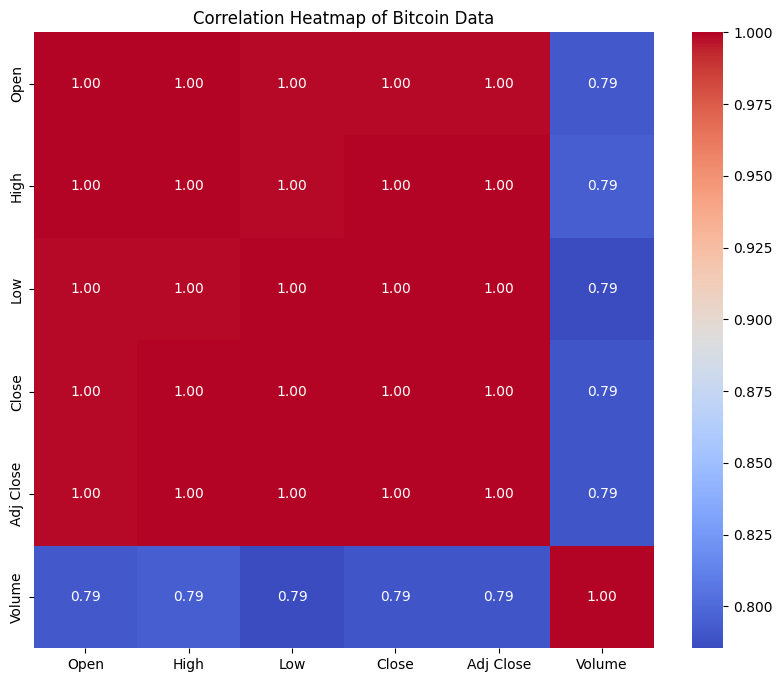

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('Date', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Bitcoin Data')
plt.show()

### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

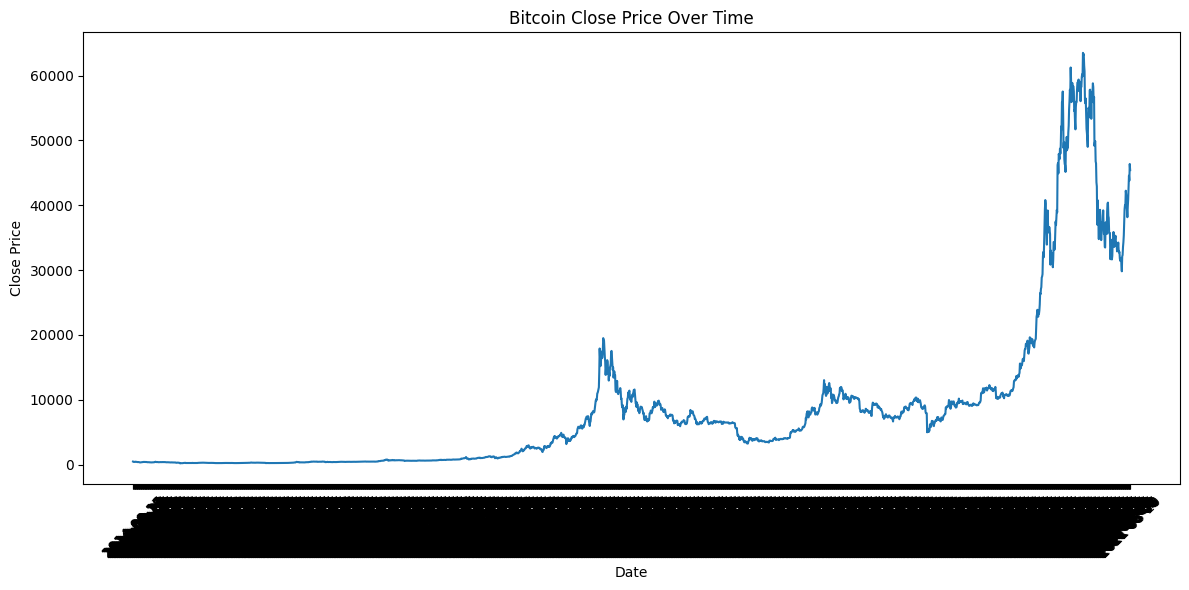

In [9]:
# YOUR CODE HERE
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Perform the Augmented Dickey-Fuller test on the original 'Close' price
result = adfuller(df['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("\nResult: The time series is likely stationary (reject the null hypothesis).")
else:
    print("\nResult: The time series is likely non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -0.038593
p-value: 0.955222
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Result: The time series is likely non-stationary (fail to reject the null hypothesis).


### Identify the trends and seasonality from the given time series data [4 points]

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing

**Note:** Ensure timeseries without NaN, inf, -inf values, Replace with 0 if found.

Read more about stationarity of a timeseries in the following [link](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [ ]:
# YOUR CODE HERE

### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

Verify the stationarity post differencing, using ADF

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
# YOUR CODE HERE

### Auto Correlation Plot [2 point]

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

In [ ]:
# YOUR CODE HERE

### Train the Auto Regressive model [2 point]

Hint: sm.tsa.AR()

In [ ]:
# YOUR CODE HERE

### ARMA Model [2 point]

* Train the ARMA model on timeseries data and print AIC value

In [ ]:
# YOUR CODE HERE for ARIMA Model

#### Plot the predictions for timeseries data [2 point]

In [ ]:
# YOUR CODE HERE

### Report Analysis

* Discuss how sudden effects of bitcoin price affects the model parameters
* State your observations about the trend and seasonality of the timeseries data
* Discuss how you selected ARMA (p and q) terms.
* Interpret the AIC value obtained for the ARMA model